In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
plt.style.use('ggplot')

In [2]:
data = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
data.head()


,id,SMILES,Tm,Group 1,Group 2,Group 3,Group 4,Group 5,Group 6,Group 7,...,Group 415,Group 416,Group 417,Group 418,Group 419,Group 420,Group 421,Group 422,Group 423,Group 424
0,2175,FC1=C(F)C(F)(F)C1(F)F,213.15,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1222,c1ccc2c(c1)ccc3Nc4ccccc4c23,407.15,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2994,CCN1C(C)=Nc2ccccc12,324.15,2,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1704,CC#CC(=O)O,351.15,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2526,CCCCC(S)C,126.15,2,3,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


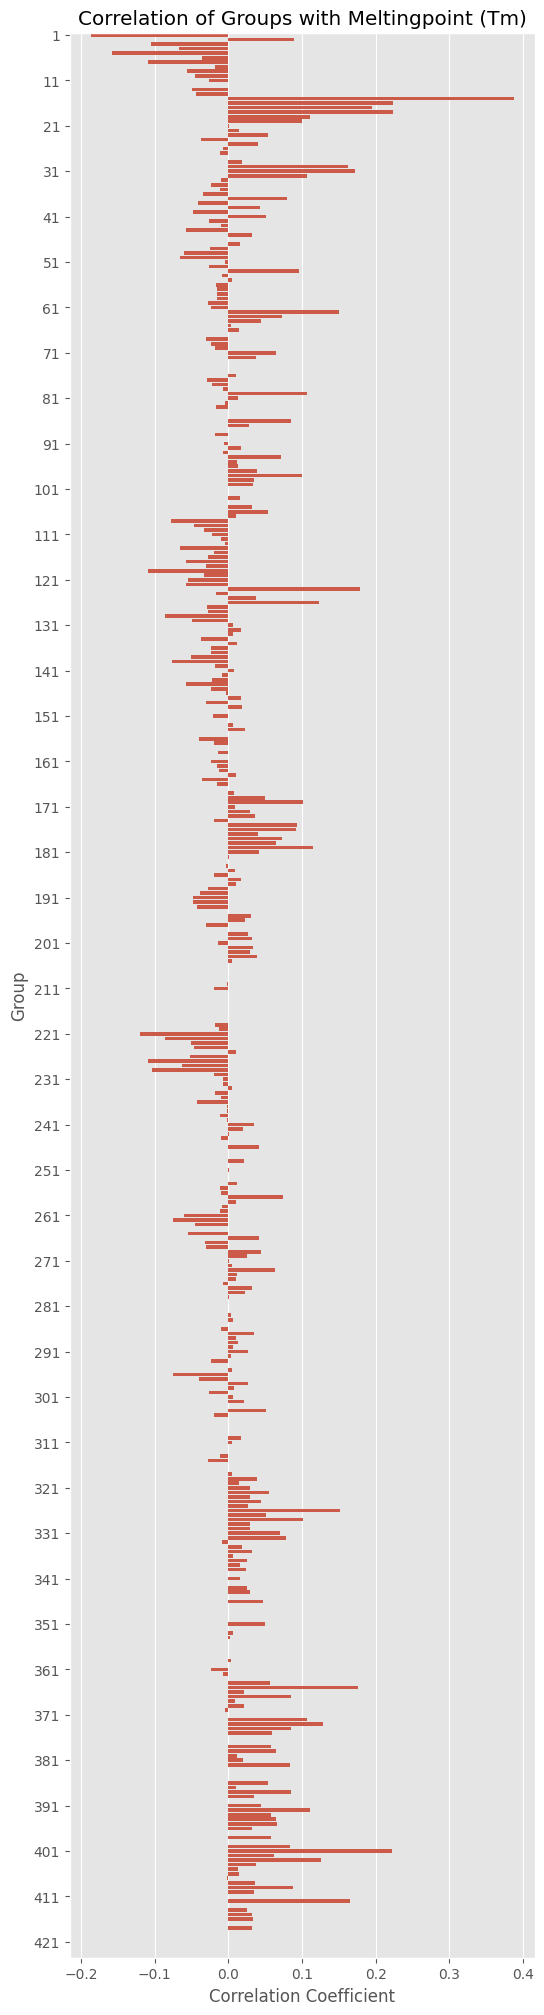

In [3]:
#plotting ideas
groups =[col for col in data.columns if col.startswith('Group')] #names of columns

corr = data[groups + ['Tm']].corr()['Tm'].drop('Tm')
corr_df = corr.reset_index()
corr_df.columns = ["Group", "Correlation"]

corr_df["Group_Number"] = corr_df["Group"].apply(lambda x: int(re.findall(r"\d+", x)[0]))

# sorting group numbers
corr_df = corr_df.sort_values("Group_Number")

plt.figure(figsize=(6, 25))
sns.barplot(data=corr_df, x="Correlation", y="Group_Number", orient="h")
step = 10
ticks = list(range(0,corr_df['Group_Number'].max() + 1, step))
plt.yticks(ticks)
plt.title("Correlation of Groups with Meltingpoint (Tm)")
plt.xlabel("Correlation Coefficient")
plt.ylabel("Group")
plt.show()

In [4]:
#methods
#KNN 
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor

X_train = data[groups]
y_train = data['Tm']
X_test = test[groups]

param_grid_knn = {
    'n_neighbors': [1,3,5,7,9,11],
    'weights': ['uniform', 'distance'],
    'p': [1,2] #1 = manhattan, 2=euclidean
}

knn = KNeighborsRegressor()
grid_knn = GridSearchCV(knn, param_grid_knn, cv=5, scoring='neg_mean_absolute_error')
grid_knn.fit(X_train, y_train)

print('Best parameters KNN:', grid_knn.best_params_)
print('Best score:', -grid_knn.best_score_)

y_pred = grid_knn.predict(X_test)

submission = pd.DataFrame({
    'id': test['id'],
    'Tm': y_pred})
submission.to_csv("predictions_KNN.csv", index=False)



Best parameters KNN: {'n_neighbors': 5, 'p': 1, 'weights': 'distance'}
Best score: 43.25191193161511


In [5]:
#neural network
from sklearn.neural_network import MLPRegressor

param_grid_mlp = {
    'hidden_layer_sizes': [(64,64), (128,64)],
    'activation': ['relu'],
    'alpha': [0.0001, 0.001],       # Regularisierung
    'learning_rate': ['adaptive']
}

mlp = MLPRegressor(max_iter=300)

grid_mlp = GridSearchCV(mlp, param_grid_mlp, cv=3, scoring="neg_mean_absolute_error")
grid_mlp.fit(X_train, y_train)

print("Beste Parameter MLP:", grid_mlp.best_params_)
print("Bester Score:", -grid_mlp.best_score_)


C:\Users\hwind\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\hwind\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\hwind\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\hwind\A

Beste Parameter MLP: {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (128, 64), 'learning_rate': 'adaptive'}
Bester Score: 37.13944238194588


C:\Users\hwind\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
